In [14]:
import numpy as np 
import pandas as pd
import sys
import gzip
import urllib.request
from sklearn.metrics import roc_curve    # for first part
from sklearn.metrics import roc_auc_score # for first part 
from matplotlib import pyplot as plt
sys.path.append('..')
from utils import tools as tl
import bioinfokit  # for volcano plots
from bioinfokit import visuz



# Getting and Processing Data
## Ideas:
##### 1- Visualization of the 'Diabetes Dataset' with Manhattan plots, pie charts from Esembl, etc... 
##### 2- Spot some interesting SNPs (enrichment patterns) and show in volcano plot



In [15]:
# load .vcf file in GHr38 format
df38 = tl.read_vcf('..\\data\\VCF_phenotypes_SNPs\\diabetes.vcf')

# drop duplicates 
df38.drop_duplicates(inplace=True)

# process
df38 = df38[~df38['CHROM'].str.contains('CHR')]
df38 = df38[~df38['ALT'].str.contains(',')]

# process dataframe for Liftover conversion (GHr38->GHr37)
df37 = df38.drop(columns=['INFO', 'FILTER', 'QUAL', 'ALT', 'REF', 'ID'])
x = df37['POS'].to_numpy()
y = x + 1
df37['POS+1'] = y
df37['CHROM'] = 'chr' + df37['CHROM'].astype(str)

# *** FILE GOES TO LIFTOVER AT THIS POINT *** #
tl.to_DeepSEAbed(df37, 'temp\\Gr38_.bed')
df37_new = tl.load_bed('temp\\GR38_converted.bed')

df37_new['ref']=df38['REF'].to_numpy()
df37_new['alt']=df38['ALT'].to_numpy()
df37_new['chromEnd'] = df38['ID'].to_numpy()
df37_new.rename(columns = {"chromEnd" : "ID"}, inplace=True)



tl.to_DeepSEAbed(df37_new, '..\\data\\VCF_test_data\\diabetes_variants.vcf')
results = tl.load_out_bed('..\\data\\VCF_test_output\\diabetes\\infile.vcf.out.logfoldchange')
e_values = x = tl.load_out_bed('..\\data\\VCF_test_output\\diabetes\\infile.vcf.out.evalue')
  

In [18]:
results.loc[results['pos'] == 97284081]


,chrom,pos,name,ref,alt,8988T|DNase|None,AoSMC|DNase|None,Chorion|DNase|None,CLL|DNase|None,Fibrobl|DNase|None,...,NHLF|H4K20me1|None,Osteoblasts|H2AZ|None,Osteoblasts|H3K27ac|None,Osteoblasts|H3K27me3|None,Osteoblasts|H3K36me3|None,Osteoblasts|H3K4me1|None,Osteoblasts|H3K4me2|None,Osteoblasts|H3K4me3|None,Osteoblasts|H3K79me2|None,Osteoblasts|H3K9me3|None
151,chr10,97284081,97284082,C,T,-0.032909,-0.25117,-0.072074,-0.010033,-0.013099,...,-0.031166,0.042636,0.085231,-0.071206,0.082535,0.054347,0.072188,0.065337,0.034952,-0.13581


# Analyzing the data (extracting meaningful information)
## Ideas:
##### 1- Visualization and identification of clusters for individual variants
##### 2- Determine possible patterns which lead to gain of function / loss of function for various TFs
##### 3- Identify possible correlations between TFs / HK /DNASE enrichment for SNPs and stratify by cell type and transcription factor class


In [13]:
# Volcano Plot for a particular SNP

snp_df = pd.DataFrame(columns = ['Names', 'log2FC', 'E-value'])
snp_e_values = e_values.drop(columns = ['chrom', 'pos', 'name', 'ref', 'alt']).iloc[204].to_numpy()
snp_logfold = results.drop(columns = ['chrom', 'pos', 'name', 'ref', 'alt']).iloc[204].to_numpy()
snp_ids = pd.DataFrame(columns=e_values.columns).drop(columns=['chrom', 'pos', 'name', 'ref', 'alt'])
snp_ids = snp_ids.columns

snp_df['log2FC'] = snp_logfold
snp_df['E-value'] = snp_e_values
snp_df['Names'] = snp_ids

snp_df
tf_labels = tl.extract_features(tf=True)
els = cols = [x for x in tf_labels if 'USF1' in x]
#els_2 = cols = [x for x in tf_labels if 'CEBPB'  in x]
visuz.gene_exp.volcano(d=snp_df, lfc="log2FC", pv="E-value", geneid="Names", genenames=({els[0]:'USF1'}), gstyle=2)


In [8]:
results

,chrom,pos,name,ref,alt,8988T|DNase|None,AoSMC|DNase|None,Chorion|DNase|None,CLL|DNase|None,Fibrobl|DNase|None,...,NHLF|H4K20me1|None,Osteoblasts|H2AZ|None,Osteoblasts|H3K27ac|None,Osteoblasts|H3K27me3|None,Osteoblasts|H3K36me3|None,Osteoblasts|H3K4me1|None,Osteoblasts|H3K4me2|None,Osteoblasts|H3K4me3|None,Osteoblasts|H3K79me2|None,Osteoblasts|H3K9me3|None
0,chr11,8243798,8243799,A,G,0.857880,-2.385200,-0.758710,0.286290,-0.168350,...,0.197950,-0.051975,0.004238,0.045417,0.405550,-0.232440,-0.070034,0.260320,0.458140,-0.104790
1,chr15,52504036,52504037,G,A,0.619860,1.693300,0.840610,0.169050,0.964850,...,0.054850,0.460610,0.470690,-0.232300,-0.317060,0.694240,0.608200,0.237890,-0.176630,0.225890
2,chr2,27851918,27851919,G,A,0.169990,0.474180,0.256310,0.328510,0.262620,...,-0.004255,-0.005726,0.109630,-0.271970,-0.008174,-0.093386,0.058052,0.118690,-0.106870,0.056194
3,chr8,19819724,19819725,C,G,-0.247190,-0.421270,-0.250940,0.456380,-0.221870,...,0.042784,-0.095785,-0.140040,0.093968,0.059705,-0.137650,-0.139140,-0.086692,0.067541,-0.073314
4,chr1,114377568,114377569,A,G,0.433190,0.262050,0.436420,0.543520,0.182300,...,-0.104990,0.347610,0.151800,-0.065824,-0.018178,0.134940,0.322360,0.343340,-0.047845,-0.169720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,chr3,187792711,187792712,T,C,0.151250,0.144530,0.125320,0.131890,0.075580,...,-0.125220,0.157790,0.036500,0.058116,-0.004579,0.027250,0.036835,0.039306,-0.074361,0.055933
632,chr3,187597927,187597928,G,A,-0.002083,0.091291,0.060422,0.011511,0.054919,...,0.059402,-0.047383,-0.021900,0.071264,0.017485,0.022197,-0.054797,-0.096469,-0.027996,0.219500
633,chr12,18779259,18779260,T,C,0.154190,0.268350,0.167400,0.179590,0.134860,...,0.101740,0.128220,0.071814,0.043530,0.043470,0.077743,0.086981,0.093442,0.065974,0.061790
634,chr2,29973281,29973282,A,C,0.014804,-0.331040,-0.012541,0.045779,-0.136480,...,0.056204,-0.115690,-0.048267,0.060200,0.057155,0.002384,-0.024928,0.014934,0.036593,0.079098


In [4]:
results = tl.load_out_bed('..\\data\\VCF_test_output\\diabetes\\infile.vcf.out.logfoldchange')
results = results.drop(columns = ['chrom', 'pos', 'name', 'ref', 'alt'])



In [47]:
cell_cols = [col for col in results.columns if 'K562' in col]
result_cell = results[cell_cols]
feature_cols = [col for col in result_cell.columns if 'H3' in col or 'Nrf' in col]

x = result_cell[feature_cols]
x


,K562|Nrf1|None,K562|H3K27ac|None,K562|H3K27me3|None,K562|H3K36me3|None,K562|H3K4me1|None,K562|H3K4me2|None,K562|H3K4me3|None,K562|H3K79me2|None,K562|H3K9ac|None,K562|H3K9me1|None,K562|H3K9me3|None
0,-0.129590,0.368230,0.139910,0.397930,0.296450,0.439390,0.504650,0.458250,0.426000,0.379070,0.052677
1,-0.108660,-0.020073,0.010369,-0.072371,0.061822,-0.057380,-0.179410,-0.094477,-0.167940,-0.061303,0.211650
2,0.257540,0.104560,-0.164600,0.007641,-0.091040,0.097930,0.116500,-0.057490,0.112130,-0.060000,0.140140
3,-0.058774,-0.095952,-0.015223,0.023523,-0.075098,-0.092216,-0.072863,0.022684,-0.082225,0.014807,-0.086240
4,0.299900,0.223760,0.181900,-0.068248,0.147090,0.345350,0.276290,-0.031960,0.253370,0.061001,-0.185420
...,...,...,...,...,...,...,...,...,...,...,...
631,0.012700,0.016104,0.105800,-0.023629,0.023450,0.012709,-0.017069,-0.084438,-0.001224,-0.028859,0.047830
632,-0.066857,-0.059190,0.083102,0.094352,0.041259,-0.100250,-0.143710,-0.052517,-0.140130,0.039737,0.169160
633,0.017566,0.054044,0.127360,0.106590,0.103370,0.063162,0.035196,0.036340,0.030262,0.111090,0.041725
634,0.065574,-0.010429,0.157520,0.066128,0.032587,0.033571,-0.032398,-0.000011,-0.060721,0.116380,0.064040


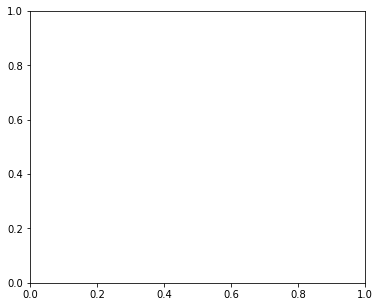

In [48]:
df = x
visuz.stat.corr_mat(df=df)

In [11]:
all_hm_features = tl.extract_features(histone_mark=True)

In [12]:
all_tf_features = tl.extract_features(tf=True)

In [13]:
all_hm_features

['H1-hESC|H2AK5ac|None',
 'H1-hESC|H2AZ|None',
 'H1-hESC|H2BK120ac|None',
 'H1-hESC|H2BK12ac|None',
 'H1-hESC|H2BK15ac|None',
 'H1-hESC|H2BK20ac|None',
 'H1-hESC|H2BK5ac|None',
 'H1-hESC|H3K14ac|None',
 'H1-hESC|H3K18ac|None',
 'H1-hESC|H3K23ac|None',
 'H1-hESC|H3K23me2|None',
 'H1-hESC|H3K27ac|None',
 'H1-hESC|H3K27me3|None',
 'H1-hESC|H3K36me3|None',
 'H1-hESC|H3K4ac|None',
 'H1-hESC|H3K4me1|None',
 'H1-hESC|H3K4me2|None',
 'H1-hESC|H3K4me3|None',
 'H1-hESC|H3K56ac|None',
 'H1-hESC|H3K79me1|None',
 'H1-hESC|H3K79me2|None',
 'H1-hESC|H3K9ac|None',
 'H1-hESC|H3K9me3|None',
 'H1-hESC|H4K20me1|None',
 'H1-hESC|H4K5ac|None',
 'H1-hESC|H4K8ac|None',
 'H1-hESC|H4K91ac|None',
 'K562|H2AZ|None',
 'K562|H3K27ac|None',
 'K562|H3K27me3|None',
 'K562|H3K36me3|None',
 'K562|H3K4me1|None',
 'K562|H3K4me2|None',
 'K562|H3K4me3|None',
 'K562|H3K79me2|None',
 'K562|H3K9ac|None',
 'K562|H3K9me1|None',
 'K562|H3K9me3|None',
 'K562|H4K20me1|None',
 'Monocytes-CD14+RO01746\xa0|H2AZ|None',
 'Monocytes-CD14

In [14]:
all_tf_features

['Dnd41|CTCF|None',
 'Dnd41|EZH2|None',
 'GM12878|CTCF|None',
 'GM12878|EZH2|None',
 'H1-hESC|CHD1|None',
 'H1-hESC|CTCF|None',
 'H1-hESC|EZH2|None',
 'H1-hESC|JARID1A|None',
 'H1-hESC|RBBP5|None',
 'HeLa-S3|CTCF|None',
 'HeLa-S3|EZH2|None',
 'HeLa-S3|Pol2(b)|None',
 'HepG2|CTCF|None',
 'HepG2|EZH2|None',
 'HMEC|CTCF|None',
 'HMEC|EZH2|None',
 'HSMM|CTCF|None',
 'HSMM|EZH2|None',
 'HSMMtube|CTCF|None',
 'HSMMtube|EZH2|None',
 'HUVEC|CTCF|None',
 'HUVEC|EZH2|None',
 'HUVEC|Pol2(b)|None',
 'K562|CHD1|None',
 'K562|CTCF|None',
 'K562|EZH2|None',
 'K562|HDAC1|None',
 'K562|HDAC2|None',
 'K562|HDAC6|None',
 'K562|p300|None',
 'K562|PHF8|None',
 'K562|PLU1|None',
 'K562|Pol2(b)|None',
 'K562|RBBP5|None',
 'K562|SAP30|None',
 'NH-A|CTCF|None',
 'NH-A|EZH2|None',
 'NHDF-Ad|CTCF|None',
 'NHDF-Ad|EZH2|None',
 'NHEK|CTCF|None',
 'NHEK|EZH2|None',
 'NHEK|Pol2(b)|None',
 'NHLF|CTCF|None',
 'NHLF|EZH2|None',
 'Osteobl|CTCF|None',
 'A549|ATF3|EtOH_0.02pct',
 'A549|BCL3|EtOH_0.02pct',
 'A549|CREB1|DEX